# Entropy-regularized Optimal Transport

This refers to the following paper by Cuturi:
> Cuturi, M. (2013). 
> Sinkhorn distances: Lightspeed computation of optimal transport. 
> In Advances in Neural Information Processing Systems (pp. 2292-2300).

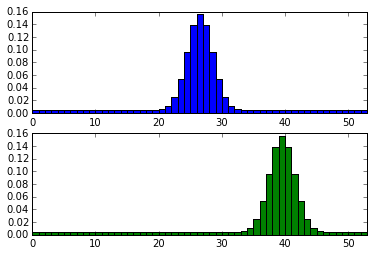

In [1]:
%matplotlib inline
import pylab
import numpy
from scipy.signal import gaussian
from scipy.spatial.distance import cdist

n = 53
h1 = gaussian(n, std=2.)
h2 = gaussian(int(1.5 * n), std=2.)[:n]
x = numpy.arange(n)
h1 += .03
h2 += .03
h1 /= numpy.sum(h1)
h2 /= numpy.sum(h2)
h1 = h1.reshape((-1, 1))
h2 = h2.reshape((-1, 1))

pylab.subplot(2, 1, 1)
_ = pylab.bar(x, h1, width=1., color="b")
_ = pylab.xlim(0, n)
pylab.subplot(2, 1, 2)
_ = pylab.bar(x, h2, width=1., color="g")
_ = pylab.xlim(0, n)

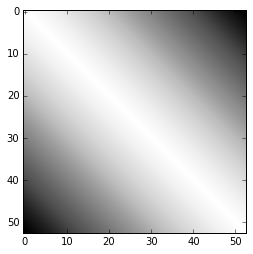

In [2]:
m = cdist(numpy.linspace(0, 1, n).reshape((-1, 1)), numpy.linspace(0, 1, n).reshape((-1, 1)))
_ = pylab.imshow(m, cmap=pylab.cm.Greys)

Then, it is time to define a Sinkhorn iteration:

In [3]:
def one_iter(a, b, p, q, xi):
    a_out = p / numpy.dot(xi, b)
    b_out = q / numpy.dot(xi.T, a)
    return a_out, b_out

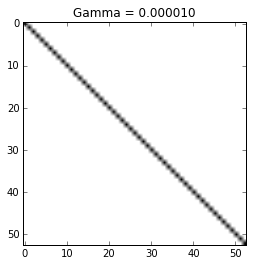

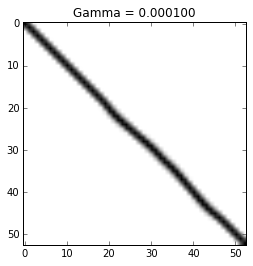

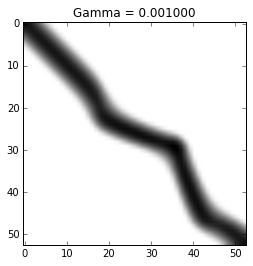

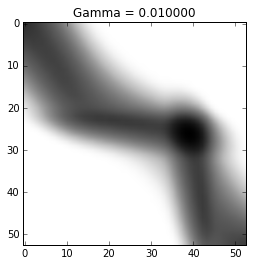

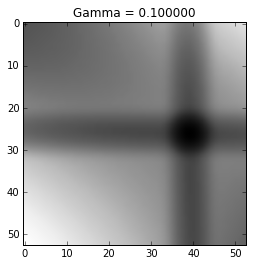

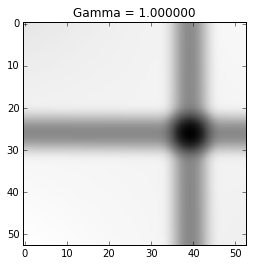

In [4]:
for gamma in [.00001, .0001, .001, .01, .1, 1.]:
    a = numpy.ones((n, 1))
    b = numpy.ones((n, 1))
    pylab.figure()
    xi = numpy.exp(-m ** 2 / gamma)
    for _ in range(10):
        a, b = one_iter(a, b, h1, h2, xi)
    pi = numpy.dot(numpy.dot(numpy.diagflat(a), xi), numpy.diagflat(b))
    _ = pylab.imshow(numpy.log(pi + 1e-6), cmap=pylab.cm.Greys)
    _ = pylab.title("Gamma = %f" % gamma)